# Импорт библиотек

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score


from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers





# Загрузка данных

In [40]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Проверка на пропуски и распределение классов

In [41]:
print("Пропущенные значения:\n", df.isnull().sum())
print("\nРаспределение классов:")
print(df['Class'].value_counts())

Пропущенные значения:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Распределение классов:
Class
0    284315
1       492
Name: count, dtype: int64


# Масштабирование и очистка

In [42]:
from sklearn.preprocessing import StandardScaler

# Масштабируем только 'Amount', удаляем 'Time'
scaler = StandardScaler()
df['Amount_scaled'] = scaler.fit_transform(df[['Amount']])
df = df.drop(['Amount', 'Time'], axis=1)


In [43]:
# Разделение данных по метке
normal_data = df[df['Class'] == 0]
fraud_data = df[df['Class'] == 1]

# Разделиение нормальных на train/test и добавление аномалий в тест
from sklearn.model_selection import train_test_split

train_normal, test_normal = train_test_split(normal_data, test_size=0.2, random_state=42)
test_data = pd.concat([test_normal, fraud_data]).sample(frac=1, random_state=42)  # перемешивание


# Выделение признаков и меток

In [44]:

X_train = train_normal.drop('Class', axis=1).values
X_test = test_data.drop('Class', axis=1).values
y_test = test_data['Class'].values


# Разделение на нормальные и аномальные данные

In [45]:

normal_data = df[df['Class'] == 0]
fraud_data = df[df['Class'] == 1]

# Тренируем только на нормальных
train_normal, test_normal = train_test_split(normal_data, test_size=0.2, random_state=42)
test_data = pd.concat([test_normal, fraud_data]).sample(frac=1, random_state=42)  # перемешать

X_train = train_normal.drop('Class', axis=1).values
X_test = test_data.drop('Class', axis=1).values
y_test = test_data['Class'].values


In [46]:
from sklearn.ensemble import IsolationForest

# Обучение Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_train)


IsolationForest(contamination=0.1, random_state=42)

# Isolation Forest

In [47]:
from sklearn.metrics import classification_report, roc_auc_score
iso_scores = -iso_forest.score_samples(X_test)

# Получаем бинарные предсказания: -1 → аномалия (1), 1 → норма (0)
y_pred_iso = iso_forest.predict(X_test)
y_pred_iso = [1 if x == -1 else 0 for x in y_pred_iso]

# Отчет по метрикам
print("Classification Report for Isolation Forest:")
print(classification_report(y_test, y_pred_iso, digits=4))

# Расчет AUC-ROC по оценкам аномальности
auc_iso = roc_auc_score(y_test, iso_scores)
print("AUC-ROC for Isolation Forest:", round(auc_iso, 4))


Classification Report for Isolation Forest:
              precision    recall  f1-score   support

           0     0.9988    0.9004    0.9471     56863
           1     0.0709    0.8780    0.1311       492

    accuracy                         0.9002     57355
   macro avg     0.5348    0.8892    0.5391     57355
weighted avg     0.9909    0.9002    0.9401     57355

AUC-ROC for Isolation Forest: 0.9491


# One-Class SVM (предварительное масштабирование)

In [48]:

scaler_ocsvm = StandardScaler()
X_train_svm = scaler_ocsvm.fit_transform(X_train)
X_test_svm = scaler_ocsvm.transform(X_test)

ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.01)
ocsvm.fit(X_train_svm)
y_pred_svm = ocsvm.predict(X_test_svm)
y_pred_svm = np.where(y_pred_svm == -1, 1, 0)

print("One-Class SVM:")
print(classification_report(y_test, y_pred_svm, digits=4))
print("AUC ROC:", roc_auc_score(y_test, y_pred_svm))


One-Class SVM:
              precision    recall  f1-score   support

           0     0.9985    0.9872    0.9928     56863
           1     0.3596    0.8333    0.5025       492

    accuracy                         0.9858     57355
   macro avg     0.6791    0.9102    0.7476     57355
weighted avg     0.9931    0.9858    0.9886     57355

AUC ROC: 0.9102477299239694


# Автоэнкодер


In [49]:

input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
encoder = Dense(7, activation='relu')(encoder)
decoder = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(input_dim, activation='linear')(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')

# Обучение
history = autoencoder.fit(X_train, X_train,
                          epochs=10,
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.1,
                          verbose=1)


Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.8629 - val_loss: 0.5124
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.4620 - val_loss: 0.4080
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3920 - val_loss: 0.3835
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3764 - val_loss: 0.3729
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.3638 - val_loss: 0.3678
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3556 - val_loss: 0.3649
Epoch 7/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.3597 - val_loss: 0.3610
Epoch 8/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3533 - val_loss: 0.3593
Epoch 9/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3492 - val_loss: 0.3572
Epoch 10/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3473 - val_loss: 0.3530


# Вычисление ошибки восстановления

In [50]:

reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)

# Установка порога: 95-й перцентиль ошибки восстановления
threshold = np.percentile(mse, 95)
y_pred_ae = (mse > threshold).astype(int)

print("Autoencoder:")
print(classification_report(y_test, y_pred_ae, digits=4))
print("AUC ROC:", roc_auc_score(y_test, mse))


1793/1793 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Autoencoder:
              precision    recall  f1-score   support

           0     0.9989    0.9572    0.9776     56863
           1     0.1510    0.8801    0.2577       492

    accuracy                         0.9565     57355
   macro avg     0.5749    0.9186    0.6177     57355
weighted avg     0.9916    0.9565    0.9714     57355

AUC ROC: 0.9672016924432122


In [52]:

# Подготовка "оценок аномальности" для AUC-ROC
score_iso = -iso_forest.score_samples(X_test)
score_svm = -ocsvm.decision_function(X_test)
score_ae = mse

# Расчет всех метрик
models = {
    "Isolation Forest": (y_pred_iso, score_iso),
    "One-Class SVM": (y_pred_svm, score_svm),
    "Autoencoder": (y_pred_ae, score_ae)
}

metrics = {
    "Model": [],
    "Precision": [],
    "Recall": [],
    "F1-score": [],
    "AUC-ROC": []
}

for name, (y_pred, scores) in models.items():
    metrics["Model"].append(name)
    metrics["Precision"].append(precision_score(y_test, y_pred))
    metrics["Recall"].append(recall_score(y_test, y_pred))
    metrics["F1-score"].append(f1_score(y_test, y_pred))
    metrics["AUC-ROC"].append(roc_auc_score(y_test, scores))

results_df = pd.DataFrame(metrics).set_index("Model")

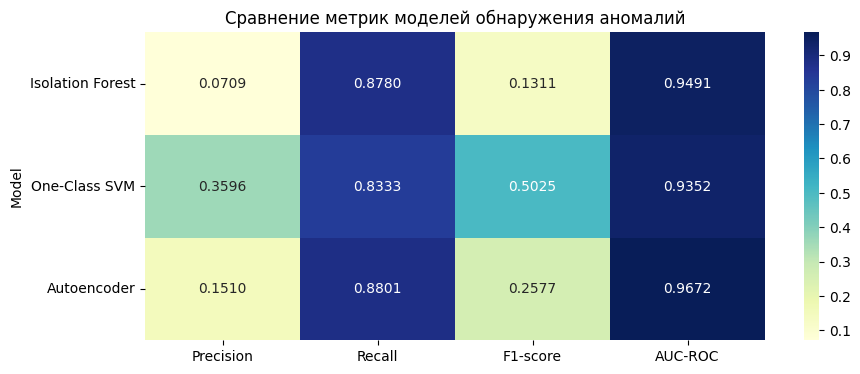

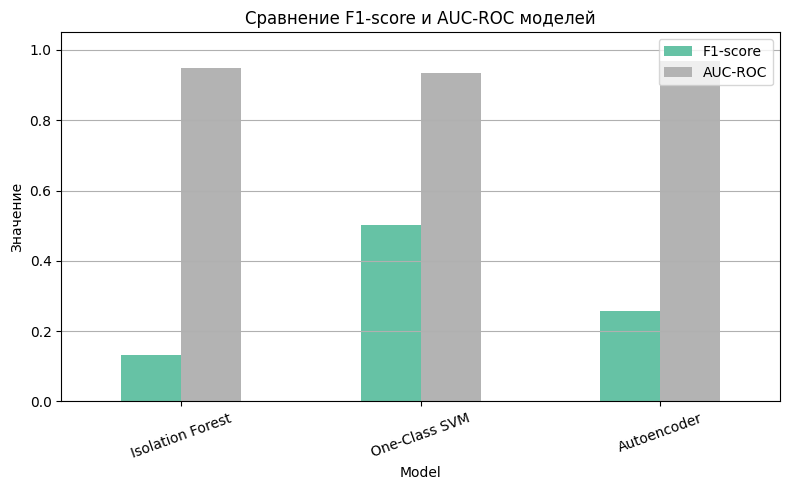

In [53]:
# Цветная таблица
plt.figure(figsize=(10, 4))
sns.heatmap(results_df, annot=True, fmt=".4f", cmap="YlGnBu", cbar=True)
plt.title("Сравнение метрик моделей обнаружения аномалий")
plt.yticks(rotation=0)
plt.show()

# Сравнение F1 и AUC-ROC
results_df[['F1-score', 'AUC-ROC']].plot(kind='bar', figsize=(8, 5), colormap='Set2')
plt.title("Сравнение F1-score и AUC-ROC моделей")
plt.ylabel("Значение")
plt.ylim(0, 1.05)
plt.grid(axis='y')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


In [60]:


def plot_individual_roc(y_true, scores, model_name):
    fpr, tpr, _ = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name}')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


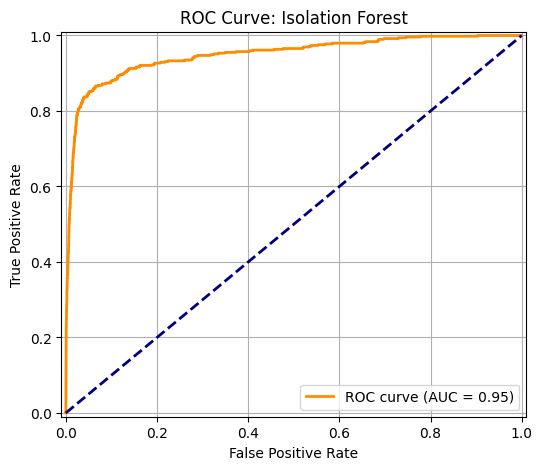

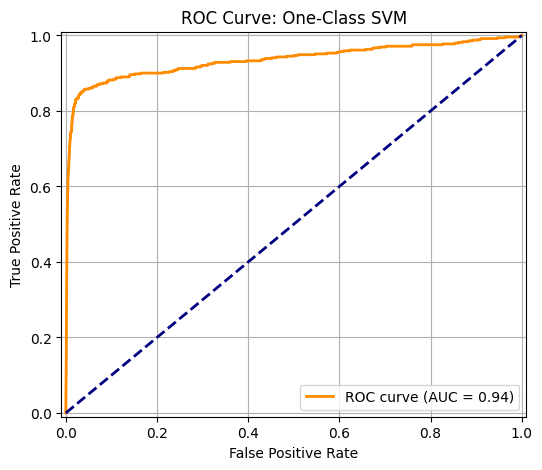

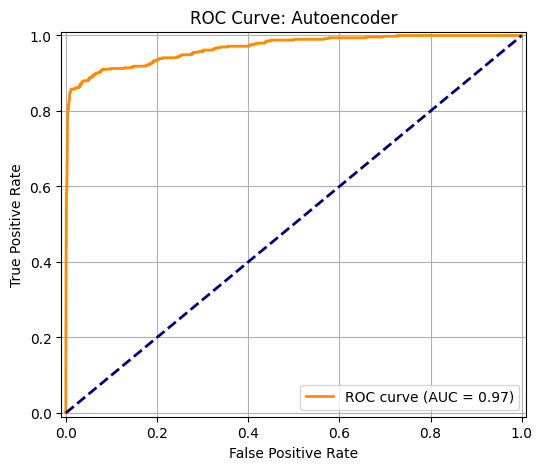

In [56]:
# ROC-кривые по отдельности
plot_individual_roc(y_test, -iso_forest.score_samples(X_test), "Isolation Forest")
plot_individual_roc(y_test, -ocsvm.decision_function(X_test), "One-Class SVM")
plot_individual_roc(y_test, mse, "Autoencoder")

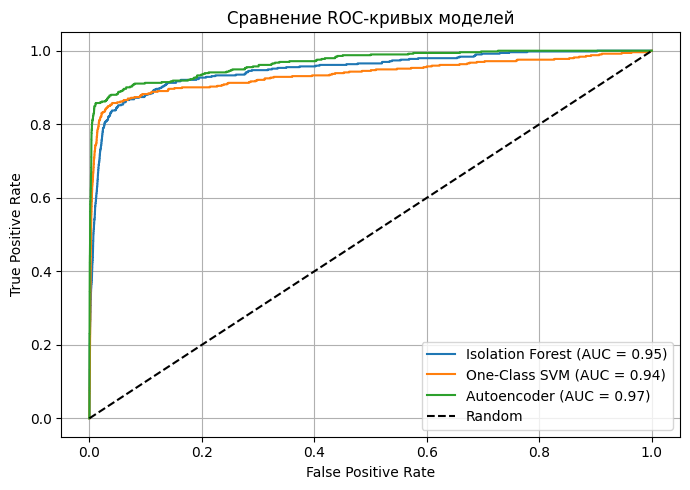

In [57]:
def plot_combined_roc():
    plt.figure(figsize=(7, 5))
    for scores, label in [
        (-iso_forest.score_samples(X_test), "Isolation Forest"),
        (-ocsvm.decision_function(X_test), "One-Class SVM"),
        (mse, "Autoencoder")
    ]:
        fpr, tpr, _ = roc_curve(y_test, scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Сравнение ROC-кривых моделей")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_combined_roc()


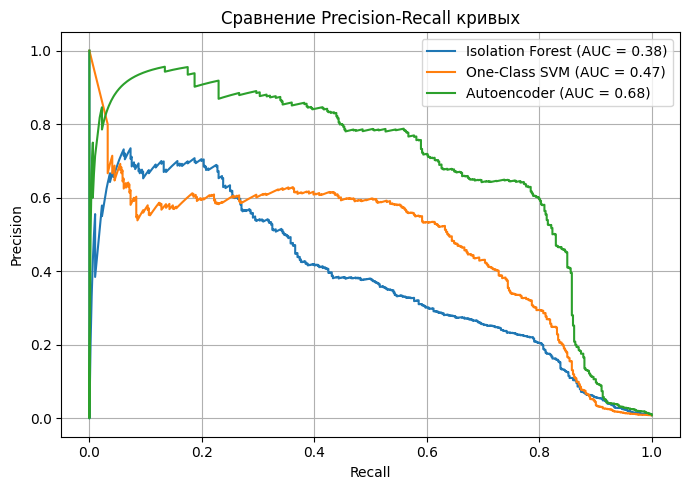

In [58]:
def plot_combined_pr():
    plt.figure(figsize=(7, 5))
    for scores, label in [
        (-iso_forest.score_samples(X_test), "Isolation Forest"),
        (-ocsvm.decision_function(X_test), "One-Class SVM"),
        (mse, "Autoencoder")
    ]:
        precision, recall, _ = precision_recall_curve(y_test, scores)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"{label} (AUC = {pr_auc:.2f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Сравнение Precision-Recall кривых")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_combined_pr()


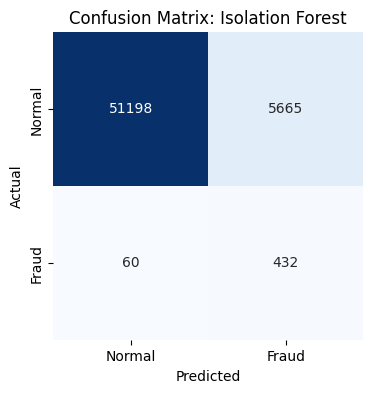

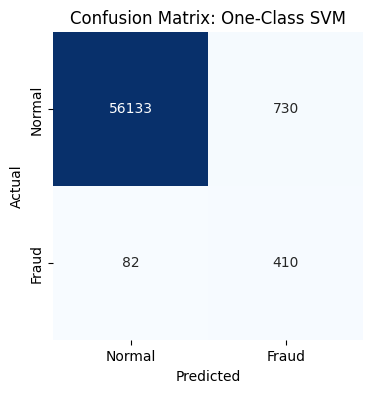

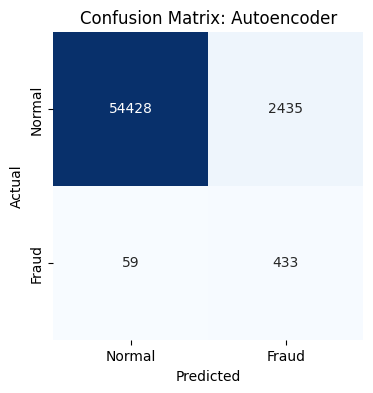

In [59]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Normal", "Fraud"],
                yticklabels=["Normal", "Fraud"])
    plt.title(title)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

plot_confusion_matrix(y_test, y_pred_iso, "Confusion Matrix: Isolation Forest")
plot_confusion_matrix(y_test, y_pred_svm, "Confusion Matrix: One-Class SVM")
plot_confusion_matrix(y_test, y_pred_ae, "Confusion Matrix: Autoencoder")
